# Named Entity Recognition with PyTorch

_Main author: Konstantin Todorov_

Goals of this laboratory:
* Learn how to use Recurrent Neural Networks (RNN)
* Learn how to perform token classification for Named Entity Recognition (NER)
* Learn which hyper-parameters are important when training on a multi-classification problem

We explore the problem of [Named Entity Recognition](https://en.wikipedia.org/wiki/Named-entity_recognition) (NER): the task of tagging each token in a given sentence with an appropriate entity label such as Person, Location, Organization, etc. Furthermore, we will use the convention that tags can start with either 'B-' or 'I-', meaning beginning or inside of a named entity respectively (for multi-token entities, e.g., "Den Haag").

# Part I: Data processing

Let's start with including the necessary libraries, setting the torch device that will be used and ensure we have reproducibility by setting a seed manually.

In [ ]:
import os
import time
import numpy as np
import random
import matplotlib.pyplot as plt
import urllib.request

import zipfile

import torch
from torch import nn
import torchtext
from collections import defaultdict, Counter

plt.rcParams["figure.figsize"] = [20,10]

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device \'{device}\'')

Using device 'cpu'


In [ ]:
# We set a seed manually for reproducing purposes. 
# This will ensure that every time you run the notebook on the same machine you will receive the same results

SEED = 42

torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

if device == 'cuda':
    torch.backends.cudnn.benchmark = False
    torch.cuda.manual_seed_all(SEED)

After we have ensured the basics, we must download the dataset we will be using. 

Below you will see a function which downloads [CoNLL-2003](https://www.clips.uantwerpen.be/conll2003/ner/) shared task dataset and stores it locally for future use.

In [ ]:
data_folder = 'data/ner'
def download_conll_2003_data(data_folder):
    if os.path.exists(data_folder) and len(os.listdir(data_folder)) > 3:
        print('CoNLL-2003 data already downloaded')
        return
    
    url = 'https://data.deepai.org/conll2003.zip'
    filename, _ = urllib.request.urlretrieve(url)
    if filename is None:
        raise Exception('Could not download CoNLL-2003 data. Please check your internet connection')
    
    with zipfile.ZipFile(filename, 'r') as zip_ref:
        zip_ref.extractall(data_folder)
        
    print('Data downloaded successfully')
    
download_conll_2003_data(data_folder)

CoNLL-2003 data already downloaded


Now that the data is downloaded, we need to define some functions to process it.

Firstly, we will define a function that given a file from the corpus, it reads it line by line and returns a collection of each word and its correct label.

In [ ]:
def read_data(corpus_file):
    with open(corpus_file, encoding='utf-8') as f:
        examples = []
        doc_words = []
        doc_labels = []
        for line in f:
            line = line.strip()
            if not line:
                examples.append((doc_words, doc_labels))

                doc_words = []
                doc_labels = []
            else:
                columns = line.split()                
                doc_words.append(columns[0])
                doc_labels.append(columns[-1])

        return examples

Further, we must also build our vocabularies. Similarly to the previous lab, we will be using TorchText and the `Vocab` object that it provides. This time, the difference will be that we must also build a vocabulary for our labels as we are now performing multi-classification instead of a binary one.

In [ ]:
from torchtext.legacy.vocab import Vocab
from collections import Counter

def build_vocabularies(train_data, vectors=None):
    counter = Counter()
    label_counter = Counter()
    for (doc_words, doc_labels) in train_data:
        counter.update(doc_words)
        label_counter.update(doc_labels)

    vocab = Vocab(counter, min_freq=1, vectors=vectors)
    label_vocab = Vocab(label_counter, min_freq=1)
    
    return vocab, label_vocab

Finally, we combine the defined functions to build data on which we can train and validate our models. In addition, we also get two vocabularies, one for the words and another for the labels.

In [ ]:
def build_data(use_pretrained = False, lower=False):
    # Read training and validation data according to the predefined split.
    train_examples = read_data(data_folder+'/train.txt')
    valid_examples = read_data(data_folder+'/valid.txt')
    test_examples = read_data(data_folder+'/test.txt')

    vectors = None
    if use_pretrained:
        vectors="glove.6B.300d"
    
    vocab, label_vocab = build_vocabularies(train_examples, vectors)
    
    return vocab, label_vocab, train_examples, valid_examples, test_examples

In [ ]:
vocab, label_vocab, train_examples, valid_examples, test_examples = build_data()

Let's investigate our vocabularies again

In [ ]:
# How many unique tokens we have in our vocabularies

print(f"Unique tokens in vocabulary: {len(vocab):,}")

Unique tokens in vocabulary: 23,626


In [ ]:
# We can also check the most common tokens in our vocabulary

print(vocab.freqs.most_common(20))

[('.', 7374), (',', 7290), ('the', 7243), ('of', 3751), ('in', 3398), ('to', 3382), ('a', 2994), ('(', 2861), (')', 2861), ('and', 2838), ('"', 2178), ('on', 2040), ('said', 1846), ("'s", 1536), ('for', 1421), ('1', 1421), ('-', 1243), ('The', 1127), ('was', 1095), ('2', 973)]


In [ ]:
# We can also see the unique tokens in our label vocabulary

print(f"Tokens in the label vocabulary: {label_vocab.freqs}")

Tokens in the label vocabulary: Counter({'O': 170524, 'B-LOC': 7140, 'B-PER': 6600, 'B-ORG': 6321, 'I-PER': 4528, 'I-ORG': 3704, 'B-MISC': 3438, 'I-LOC': 1157, 'I-MISC': 1155})


In [ ]:
# How the data looks like
# Each datapoint is a sentence tokenized and labelled into two lists within a tuple. The tag 'O' means not a named entity

train_examples[:3]

[(['-DOCSTART-'], ['O']),
 (['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.'],
  ['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O']),
 (['Peter', 'Blackburn'], ['B-PER', 'I-PER'])]

One of the final steps in pre-processing is to convert the raw texts we have to their integer versions. For each pair of word-label we convert it to their respective ids in the word and label vocabularies. 

We do this for the training, as well as for the test and validation datasets.

In [ ]:
def convert_examples_to_tokens(examples, vocab, label_vocab):
    result = []
    for doc_words, doc_labels in examples:
        word_tokens = [vocab[word] for word in doc_words]
        label_tokens = [label_vocab[label] for label in doc_labels]
        result.append((word_tokens, label_tokens))
        
    return result

In [ ]:
train_tokens = convert_examples_to_tokens(train_examples, vocab, label_vocab)
valid_tokens = convert_examples_to_tokens(valid_examples, vocab, label_vocab)
test_tokens = convert_examples_to_tokens(test_examples, vocab, label_vocab)

Now that we have the data ready for use, we must make one final adjustment. At every step during training, we must organize our data neatly in a batch. If you recall from last exercise, we use PyTorch's data loaders and specifically their `collate_fn` argument. 

Below, we define a function `collate_batch` which accepts the batch and information about the padding and transforms and sorts it before returning the sequences, labels and lengths of sequences as tensors in the end.

In [ ]:
from torch.utils.data import DataLoader

def collate_batch(batch, label_pad_idx=1):
    batch_size = len(batch)
    word_list = []
    label_list = []
    
    # Create lists for labels and texts
    for (word_tokens, label_tokens) in batch:
        word_list.append(word_tokens)
        label_list.append(label_tokens)

    # Put all texts into a single numpy array of uniform length
    # For all sequences that are shorther than the maximum length, pad to the right with 0
    lengths = [len(words) for words in word_list]
    max_length = max(lengths)
    padded_sequences = np.zeros((batch_size, max_length), dtype=np.int64)
    padded_labels = np.zeros((batch_size, max_length), dtype=np.int64)
    padded_labels.fill(label_pad_idx)

    for i, length in enumerate(lengths):
        padded_sequences[i][0:length] = word_list[i][0:length]
        padded_labels[i][0:length] = label_list[i][0:length]
        
    # Finally transform the arrays into tensors and return to the dataloader
    sequences_tensor = torch.from_numpy(padded_sequences).to(device)
    label_tensor = torch.from_numpy(padded_labels).to(device)
    
    # Sort the tensors by length
    seq_lengths, perm_idx = torch.tensor(lengths).sort(0, descending=True)
    sequences_tensor = sequences_tensor[perm_idx]
    label_tensor = label_tensor[perm_idx]
    return sequences_tensor, label_tensor, seq_lengths

Now, to define the dataloaders we will be using throughout the training, we create the `get_dataloaders` function

In [ ]:
def get_dataloaders(train_tokens, valid_tokens, test_tokens, pad_idx, label_pad_idx, batch_size):
    train_dataloader = DataLoader(
        train_tokens,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=collate_batch)
    
    valid_dataloader = DataLoader(
        valid_tokens,
        batch_size=batch_size,
        collate_fn=collate_batch)
    
    test_dataloader = DataLoader(
        test_tokens,
        batch_size=batch_size,
        collate_fn=collate_batch)
    
    return train_dataloader, valid_dataloader, test_dataloader

In [ ]:
BATCH_SIZE = 512
pad_idx = vocab['<pad>']
label_pad_idx = label_vocab['<pad>']

(train_dataloader, valid_dataloader, test_dataloader) = get_dataloaders(
    train_tokens, valid_tokens, test_tokens, pad_idx, label_pad_idx, BATCH_SIZE)

Due to the nature of the NER task, we see that the amount of non tagged words compared to our other tags is much higher.

In [ ]:
non_tagged_percentage = (label_vocab.freqs['O'] / sum(label_vocab.freqs.values())) * 100

print(f'Percentage of non tagged words: {non_tagged_percentage:.4}%')

Percentage of non tagged words: 83.36%


This means that metrics that we usually use such as accurracy will not work here. If we do use it, our model learning to predict **only** 'O' will easily achieve accurracy of at least the value above. We must rely on another metric, namely the F1 score which takes into account the precision and recall of the model predictions and does not allow for a single tag to dominate the result.

Using the F1 score requires us to define multiple functions that are required to evaluate our predictions and compare them to the ground truth labels. Below, you will see the definitions functions, commented on how they are working exactly. 

In [ ]:
# Convert a list of BIO labels, coded as integers, into spans identified by a beginning, an end, and a label.
# To allow easy comparison later, we store them in a dictionary indexed by the start position.
def to_spans(l_ids, voc):
    spans = {}
    current_lbl = None
    current_start = None
    
    for i, l_id in enumerate(l_ids):
        l = voc[l_id]

        if l[0] == 'B': 
            # Beginning of a named entity: B-something.
            if current_lbl:
                # If we're working on an entity, close it.
                spans[current_start] = (current_lbl, i)
                
            # Create a new entity that starts here.
            current_lbl = l[2:]
            current_start = i
        elif l[0] == 'I':
            # Continuation of an entity: I-something.
            if current_lbl:
                # If we have an open entity, but its label does not
                # correspond to the predicted I-tag, then we close
                # the open entity and create a new one.
                if current_lbl != l[2:]:
                    spans[current_start] = (current_lbl, i)
                    current_lbl = l[2:]
                    current_start = i
            else:
                # If we don't have an open entity but predict an I tag,
                # we create a new entity starting here even though we're
                # not following the format strictly.
                current_lbl = l[2:]
                current_start = i
        else:
            # Outside: O.
            if current_lbl:
                # If we have an open entity, we close it.
                spans[current_start] = (current_lbl, i)
                current_lbl = None
                current_start = None

    return spans

In [ ]:
# Compares two sets of spans and records the results for future aggregation
def compare(gold, pred, stats):
    for start, (lbl, end) in gold.items():
        stats['total']['gold'] += 1
        stats[lbl]['gold'] += 1
        
    for start, (lbl, end) in pred.items():
        stats['total']['pred'] += 1
        stats[lbl]['pred'] += 1
        
    for start, (glbl, gend) in gold.items():
        if start in pred:
            plbl, pend = pred[start]
            if glbl == plbl and gend == pend:
                stats['total']['corr'] += 1
                stats[glbl]['corr'] += 1

# Computes precision, recall and F-score, given a dictionary that contains
# the counts of correct, predicted and gold-standard items
def prf(stats):
    if stats['pred'] == 0:
        return 0, 0, 0
    
    p = stats['corr']/stats['pred']
    r = stats['corr']/stats['gold']
    if p > 0 and r > 0:
        f = 2*p*r/(p+r)
    else:
        f = 0
    return p, r, f

# This function combines the auxiliary functions we defined above.
def evaluate_iob(predicted, gold, label_vocab, stats):
    # The gold-standard labels are assumed to be an integer tensor of shape
    # [batch_size x max_length], as returned by the dataloader.
    gold_cpu = gold.cpu().numpy()
    gold_cpu = list(gold_cpu.reshape(-1))

    # We just flatten the list.
    pred_cpu = [l for sen in predicted for l in sen]
    
    # Compute spans for the gold standard and prediction.
    gold_spans = to_spans(gold_cpu, label_vocab.itos)
    pred_spans = to_spans(pred_cpu, label_vocab.itos)

    # Finally, update the counts for correct, predicted and gold-standard spans.
    compare(gold_spans, pred_spans, stats)

# Part II: Model

We now define our tagger model. Below, you will see the declaration of `RNNTagger`. 

There are multiple interesting points. For layers, we make use of the embedding layer we learned before, as well as an RNN layer. In the end, we end up with a linear layer which maps the dimension down to the desired output.

The RNN layer is custom and is defined based on an argument. We define two types -- the most simple one -- a basic Recurrent neural network (RNN) and one that has become increasingly more popular in the recent years: [Gated Recurrent Unit (GRU)](https://en.wikipedia.org/wiki/Gated_recurrent_unit). You can think of GRUs as simpler LSTMs, where there is not cell state but only gates. As a consequence, GRUs are less expressive but much faster than LSTMs. 

Besides the required `.forward()` definition, we define `.predict()` function which we will use for evaluation over the trained model later on.

In [ ]:
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class RNNTagger(nn.Module):
    
    def __init__(
        self,
        vocab_size,
        embedding_dim,
        hidden_size,
        output_dim,
        pad_word_idx,
        pad_label_idx,
        n_layers=1,
        bidirectional=True,
        rnn_type='rnn',
        pretrained_weights=None,
        update_pretrained=False):
        super().__init__()
        
        # Embedding layer
        # If we're using pre-trained embeddings, copy them into our embedding module.
        self._embedding_layer = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_word_idx)
        if pretrained_weights is not None:
            self._embedding_layer.weight = torch.nn.Parameter(
                pretrained_weights,
                requires_grad=update_pretrained)

        # RNN layer
        # This depends on the argument passed. We can use RNN, GRU or LSTM
        if rnn_type == 'rnn':
            self._rnn_layer = nn.RNN(
                input_size=embedding_dim,
                hidden_size=hidden_size,
                bidirectional=bidirectional,
                num_layers=n_layers)
        elif rnn_type == 'gru':
            self._rnn_layer = nn.GRU(
                input_size=embedding_dim,
                hidden_size=hidden_size,
                bidirectional=bidirectional,
                num_layers=n_layers)
        else:
            raise Exception('Unsupported RNN type')

        rnn_output_size = hidden_size
        if bidirectional:
            rnn_output_size = rnn_output_size * 2
            
        # Output layer
        # The input of this layer is the output of the RNN layer
        # Since we are always using bi-directional RNN, we multiply the RNN hidden size by 2
        self._fc_layer = nn.Linear(rnn_output_size, output_dim)
 
        # To deal with the padding positions later, we need to know the
        # ids of the word pad tokens and the label pad tokens
        self._pad_word_idx = pad_word_idx
        self._pad_label_idx = pad_label_idx
          
    def forward(self, sentences, lengths):
        # The words in the documents are encoded as integers. The shape of the documents
        # tensor is [batch_size x max_length]
        # where batch_size is the number of documents in this batch,
        # and max_length is the maximal length of a document in the batch.

        # We first look up the embeddings for all the words in the documents.
        # The shape is now  [batch_size x max_length x embedding_dim]
        embedded = self._embedding_layer.forward(sentences)

        # We pack the padded sequence
        # This is done for performance reasons and to ease the RNN training
        # What packing does is to avoid iterating over padded tokens
        packed_embeddings = pack_padded_sequence(embedded, lengths, batch_first=True, enforce_sorted=True)

        # We push the packed input to the RNN layer
        # The shape of the RNN output tensor is now [batch_size x max_length x rnn_output_size]
        out_packed, _ = self._rnn_layer.forward(packed_embeddings)
        
        # We revert the packed output to a format similar to the original padded one
        rnn_out, _ = pad_packed_sequence(out_packed, batch_first=True)
        
        # We then apply the linear output layer
        # The shape of the output tensor is [batch_size x max_length x output_dim]
        out = self._fc_layer.forward(rnn_out)
        
        # We can end the forward pass here. 
        # However, in order to ease the loss calculation, 
        # we configure the probability for the pad tokens manually so that the process progresses quicker
        
        # Find the positions where the token is a dummy padding token.
        pad_mask = (sentences == self._pad_word_idx).float()

        # For these positions, we add some large number in the column corresponding
        # to the dummy padding label.
        out[:, :, self._pad_label_idx] += pad_mask*10000
        
        return out

    def predict(self, sentences, lengths):
        # Compute the outputs from the linear units.
        
        # scores is [batch_size x max_length x output_dim]
        scores = self.forward(sentences, lengths)
        
        # Select the top-scoring labels
        # predicted is [batch_size x max_length]
        predicted = scores.argmax(dim=2)

        # We convert the prediction to a NumPy matrix.
        return scores, predicted.cpu().numpy()

# Part III: Training

We define the training function below. In addition to that, we define helper functions about printing the statistics during evaluation and calculating the loss given the defined criterion and the predictions versus ground truth labels.

As you can see, the training process is very similar to what we used for simpler models.

In [ ]:
def calculate_loss(criterion, scores, labels):
    # We must flatten the scores into [(batch_size*max_length) x output_dim]
    scores = scores.view(-1, scores.shape[2])
    
    # Same goes for labels. They now have a shape of [(batch_size*max_length)]
    labels = labels.view(-1) 
    loss = criterion.forward(scores, labels) / scores.shape[0]
    return loss

def print_evaluation_stats(stats):
    print()
    print('Final evaluation on the validation set:')
    p, r, f1 = prf(stats['total'])
    print(f'Overall: P = {p:.4f}, R = {r:.4f}, F1 = {f1:.4f}')
    for label in stats:
        if label != 'total':
            p, r, f1 = prf(stats[label])
            print(f'{label:4s}: P = {p:.4f}, R = {r:.4f}, F1 = {f1:.4f}')

def train(
    model,
    train_dataloader,
    valid_dataloader,
    label_vocab,
    pad_idx=1,
    n_epochs=15):
    
    # Adam optimizer that will update the parameters of our model
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-5)
    
    # Loss function that we will use during training
    criterion = torch.nn.CrossEntropyLoss(reduction='sum', ignore_index=pad_idx)
    history = defaultdict(list)

    for epoch in range(1, n_epochs + 1):

        t0 = time.time()

        loss_sum = 0

        model.train()
        for i, (text, labels, lengths) in enumerate(train_dataloader):
            
            # Print the progress during training
            print(f'{i}/{len(train_dataloader)}                           \r', end='')
            
            # Compute the output and loss.
            scores = model.forward(text, lengths)
            
            # Calculate the loss
            loss = calculate_loss(criterion, scores, labels)
            
            # Zero the gradients before performing the backward pass
            optimizer.zero_grad()
            
            # Perform the backward pass
            loss.backward()
            
            # Make a step in the parameter space
            optimizer.step()
            
            # Save the loss value for future references
            loss_sum += loss.item()

        # Calculate the average loss for the full epoch and save it to the history
        train_loss = loss_sum / len(train_dataloader)
        history['train_loss'].append(train_loss)

        # Evaluate on the validation set.
        stats = defaultdict(Counter)
        
        model.eval()
        with torch.no_grad():
            val_loss_sum = 0
            for (text, labels, lengths) in valid_dataloader:
                # Predict the model's output on a batch.
                scores, predicted = model.predict(text, lengths)
                
                # Calculate the loss and store it
                loss = calculate_loss(criterion, scores, labels)
                val_loss_sum += loss.item()
                
                # Update the evaluation statistics.
                # This function modifies the stats object
                evaluate_iob(predicted, labels, label_vocab, stats)

        # Compute the overall F1 score for the validation set
        _, _, val_f1 = prf(stats['total'])

        # Save the validation results to the history
        history['val_f1'].append(val_f1)
        val_loss = val_loss_sum / len(valid_dataloader)
        history['val_loss'].append(val_loss)

        # Print some information about the epoch
        t1 = time.time()
        print(f'Epoch {epoch}: train loss = {train_loss:.4f}, val f1: {val_f1:.4f}, time = {t1-t0:.4f}')

    # After the final evaluation, we print more detailed evaluation statistics, including
    # precision, recall, and F-scores for the different types of named entities.
    print_evaluation_stats(stats)

    return history

Let's now initialize our `RNNTagger` and finally train it.

In [ ]:
rnn_model = RNNTagger(
    vocab_size=len(vocab),
    embedding_dim=300,
    hidden_size=256,
    output_dim=len(label_vocab),
    pad_word_idx=1,
    pad_label_idx=1,
    bidirectional=True,
    n_layers=1).to(device)

In [ ]:
train_history = train(rnn_model, train_dataloader, valid_dataloader, label_vocab)

Epoch 1: train loss = 0.2347, val f1: 0.2313, time = 55.3399
Epoch 2: train loss = 0.1096, val f1: 0.4710, time = 53.3496
Epoch 3: train loss = 0.0650, val f1: 0.5803, time = 55.7240
Epoch 4: train loss = 0.0424, val f1: 0.6455, time = 53.7209
Epoch 5: train loss = 0.0301, val f1: 0.6790, time = 53.6060
Epoch 6: train loss = 0.0232, val f1: 0.7122, time = 53.3563
Epoch 7: train loss = 0.0191, val f1: 0.7140, time = 52.7267
Epoch 8: train loss = 0.0147, val f1: 0.7517, time = 55.4673
Epoch 9: train loss = 0.0117, val f1: 0.7857, time = 52.7219
Epoch 10: train loss = 0.0104, val f1: 0.7822, time = 53.9339
Epoch 11: train loss = 0.0103, val f1: 0.8150, time = 53.7225
Epoch 12: train loss = 0.0161, val f1: 0.5908, time = 52.6336
Epoch 13: train loss = 0.0203, val f1: 0.7825, time = 56.6578
Epoch 14: train loss = 0.0091, val f1: 0.8065, time = 54.8291
Epoch 15: train loss = 0.0080, val f1: 0.7966, time = 50.7090

Final evaluation on the validation set:
Overall: P = 0.8497, R = 0.7497, F1 = 

Now that our model is trained, let's see how the loss progressed during the epochs.

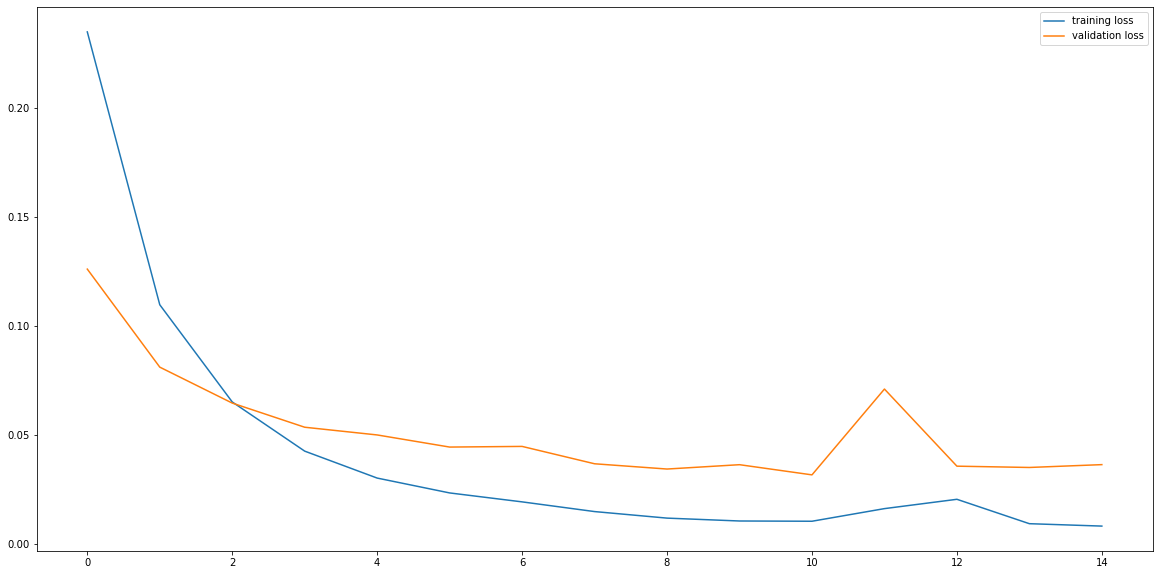

In [ ]:
def plot_loss_stats(train_history):
    plt.plot(train_history['train_loss'])
    plt.plot(train_history['val_loss'])
    plt.legend(['training loss', 'validation loss'])
    plt.show()

plot_loss_stats(train_history)

What about the F1 score of the validation set?

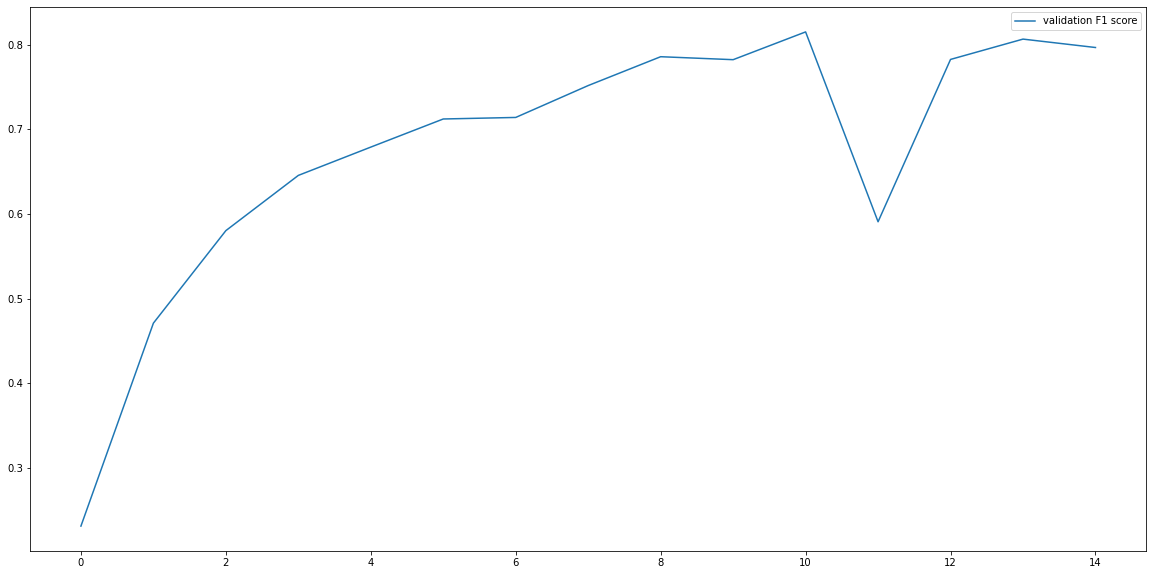

In [ ]:
def plot_f1_stats(train_history):
    plt.plot(train_history['val_f1'])
    plt.legend(['validation F1 score'])
    plt.show()

plot_f1_stats(train_history)

# Part IV: Evaluation

Everything seems in order. But we can never be too certain unless we try the model on unseen data. Let's define some functions that will help us do that. 

Firstly, we define the `create_evaluation_dataloader` helper function which builds a dataloader from raw sentences (represented as lists of list of tokens). Secondly, we have the `evaluate_sentences` which takes the tokens and the model, iterates over the data and predicts the labels. It then returns a collection of pairs -- a token and its corresponding predicted label.

In [ ]:
def create_evaluation_dataloader(sentences, vocab, label_vocab, device):    
    # First, create a torchtext Dataset containing the sentences to tag.
    examples = []
    for sen in sentences:
        labels = ['?']*len(sen) # placeholder
        examples.append((sen, labels))
    
    
    tokens = convert_examples_to_tokens(examples, vocab, label_vocab)
    
    dataloader = DataLoader(
        tokens,
        batch_size=BATCH_SIZE,
        collate_fn=lambda x: collate_batch(x))
    
    return dataloader

def evaluate_sentences(sentences, model, vocab, label_vocab, device):
    # This method applies the trained model to a list of sentences.
    dataloader = create_evaluation_dataloader(sentences, vocab, label_vocab, device)

    # Apply the trained model to all batches.
    out = []
    model.eval()
    with torch.no_grad():
        for (text, _, lengths) in dataloader:
            # Call the model's predict method. This returns a list of NumPy matrix
            # containing the integer-encoded tags for each sentence.
            _, predicted = model.predict(text, lengths)

            # Convert the integer-encoded tags to tag strings.
            for tokens, pred_sen in zip(sentences, predicted):
                out.append([
                    (token, label_vocab.itos[pred_id])
                    for token, pred_id in zip(tokens, pred_sen)
                ])

    return out

Finally, we create the `print_tags` function which wraps what we just defined and prints the predictions in the end.

In [ ]:
def print_tags(model, vocab, label_vocab, device, sentence):
    tokens = sentence.split()
    token_tags = evaluate_sentences([tokens], model, vocab, label_vocab, device)[0]
    for token, tag in token_tags:
        print(f'{token:12s}{tag}')

In [ ]:
print_tags(
    rnn_model,
    vocab,
    label_vocab,
    device,
    'John Johnson was born in Moscow , lives in Gothenburg , and works for Chalmers \
    Technical University and the University of Gothenburg .')

John        B-PER
Johnson     I-PER
was         O
born        O
in          O
Moscow      B-LOC
,           O
lives       O
in          O
Gothenburg  B-LOC
,           O
and         O
works       O
for         O
Chalmers    B-ORG
Technical   I-ORG
University  I-ORG
and         O
the         O
University  I-ORG
of          I-ORG
Gothenburg  I-ORG
.           O


It seems as if the model is capable to predict the entities correctly. As a final test, let's run the model over our test dataset and plot a confusion matrix for the results. Confusion matrices, also known as error matrices, allow us to better visualise our algorithm and to see if there are many mismatched entities. For example, we could see that the Person entity is often misrepresented as Location or similar.

A perfect scenario would be a confusion matrix that has only its diagonal lit up. This would mean that X entity is predicted as X always and no confusions are occurring.

In [ ]:
def evaluate_on_test(model, test_dataloader):
    test_labels = []
    test_predictions = []

    for (text, labels, lengths) in test_dataloader:
        _, predictions = model.predict(text, lengths)
        test_labels.extend(labels.reshape(-1).detach().cpu().tolist())
        test_predictions.extend(predictions.reshape(-1).tolist())

    test_labels = [label_vocab.itos[x] for x in test_labels]
    test_predictions = [label_vocab.itos[x] for x in test_predictions]
    
    return (test_labels, test_predictions)

In [ ]:
from sklearn import metrics
import seaborn as sns

def plot_confusion_matrix(test_labels, test_predictions, label_vocab):
    # we take all label strings
    labels = label_vocab.itos
    
    # calculate the confusion matrix and normalize it
    cm = metrics.confusion_matrix(test_labels, test_predictions, labels=labels)
    cm = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + 1) # we add 1 to avoid division by zero

    # plot the confusion matrix using seaborn heatmap
    sns_heatmap = sns.heatmap(
        cm,
        cmap='RdYlGn_r',
        square=True,
        vmin=0,
        vmax=1)

    # beautify the plot so that it has better readability
    plt.ylim(0, len(labels) + 0.5)
    plt.ylim(0, len(labels) + 0.5)
    plt.xlabel('Predicted values', labelpad=20)
    plt.ylabel('True values')

    sns_heatmap.set_yticklabels(labels, rotation=0)
    sns_heatmap.set_xticklabels(labels, rotation=45, horizontalalignment='right')

    plt.show()

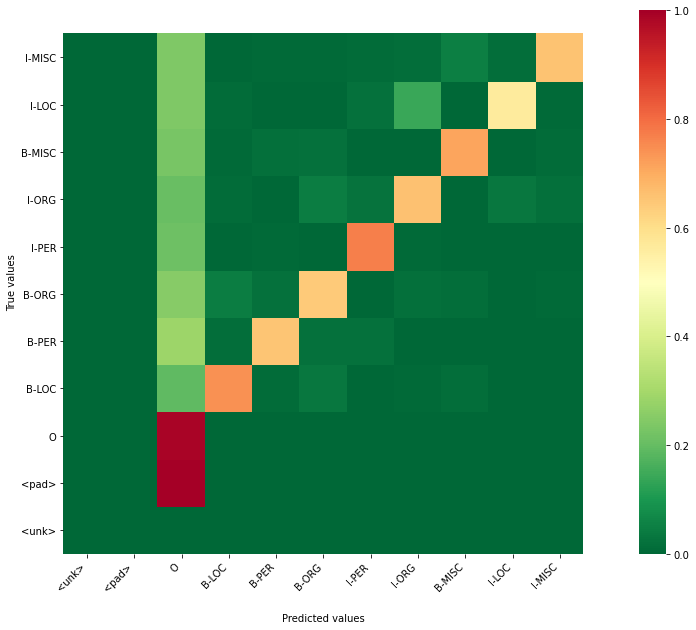

In [ ]:
test_labels, test_predictions = evaluate_on_test(rnn_model, test_dataloader)
plot_confusion_matrix(test_labels, test_predictions, label_vocab)

As we can see from our confusion matrix, the 'O' entity is the one causing most problems. This is to be expected, given its high occurrence in our data. We also see that there is still room for improvement, so let's try just that.

# Part V: Gated Recurrent Unit (GRU)

We now define a Gated Recurrent Unit (GRU) using our previously defined `RNNTagger` model. The only difference is that we are passing the `rnn_type` argument with a value of 'gru'. 

Let's train the model and observe if there is any difference to the previous results.

In [ ]:
gru_model = RNNTagger(
    vocab_size=len(vocab),
    embedding_dim=300,
    hidden_size=256,
    output_dim=len(label_vocab),
    pad_word_idx=1,
    pad_label_idx=1,
    bidirectional=True,
    n_layers=1,
    rnn_type='gru').to(device)

In [ ]:
gru_history = train(gru_model, train_dataloader, valid_dataloader, label_vocab)

Epoch 1: train loss = 0.1674, val f1: 0.5140, time = 96.6758
Epoch 2: train loss = 0.0586, val f1: 0.6690, time = 91.3660
Epoch 3: train loss = 0.0320, val f1: 0.6969, time = 87.2386
Epoch 4: train loss = 0.0207, val f1: 0.7065, time = 91.9458
Epoch 5: train loss = 0.0149, val f1: 0.7120, time = 91.4818
Epoch 6: train loss = 0.0111, val f1: 0.7017, time = 92.8732
Epoch 7: train loss = 0.0104, val f1: 0.6957, time = 90.3470
Epoch 8: train loss = 0.0084, val f1: 0.7377, time = 91.7385
Epoch 9: train loss = 0.0085, val f1: 0.7580, time = 92.6882
Epoch 10: train loss = 0.0079, val f1: 0.7815, time = 95.7857
Epoch 11: train loss = 0.0076, val f1: 0.7810, time = 93.5209
Epoch 12: train loss = 0.0058, val f1: 0.8097, time = 95.6356
Epoch 13: train loss = 0.0063, val f1: 0.8292, time = 93.5036
Epoch 14: train loss = 0.0064, val f1: 0.8226, time = 91.7749
Epoch 15: train loss = 0.0055, val f1: 0.8300, time = 89.4628

Final evaluation on the validation set:
Overall: P = 0.8794, R = 0.7858, F1 = 

Let's plot our training stats, similar to our previous model.

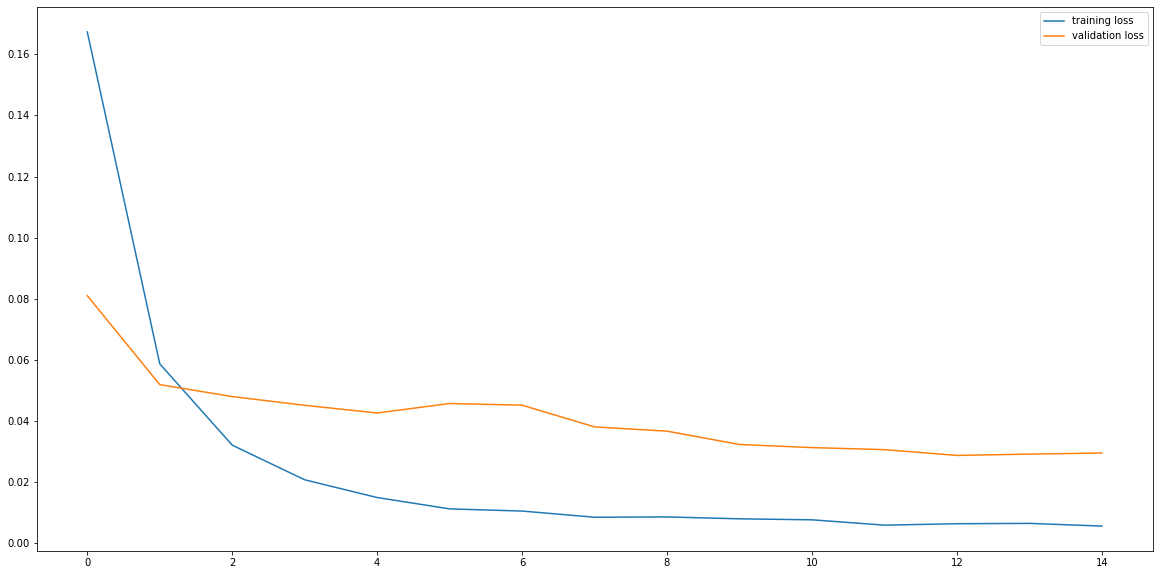

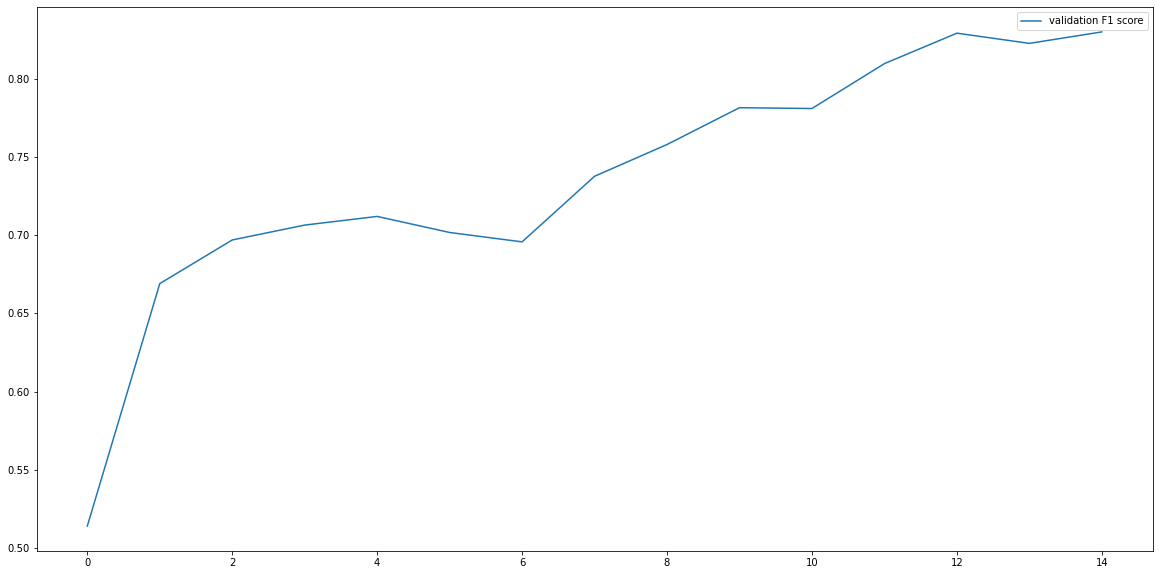

In [ ]:
plot_loss_stats(gru_history)
plot_f1_stats(gru_history)

While these look good again, we need to be able to compare them with the previous ones. Below, we have a function that plots the f1 score history of our models together so that we can seee the difference.

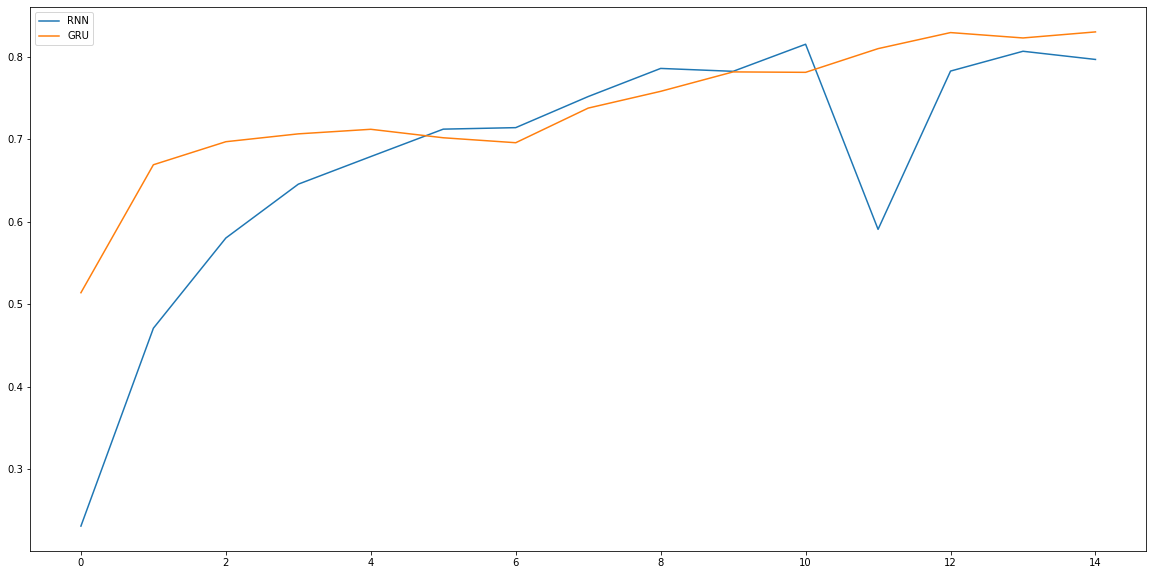

In [ ]:
def compare_results(history_results, result_labels):
    for result in history_results:
        plt.plot(result['val_f1'])
        
    plt.legend(result_labels)
    plt.show()
    
compare_results([train_history, gru_history], ['RNN', 'GRU'])

We can see that GRU outperforms the RNN model. This is to be expected and is the reason to why many scientists stick to it when working with recurrent networks. 

As a final check, let's see the confusion matrix of our GRU model too. Given the comparisons we saw, it should look better. Is this true? What is better or worse?

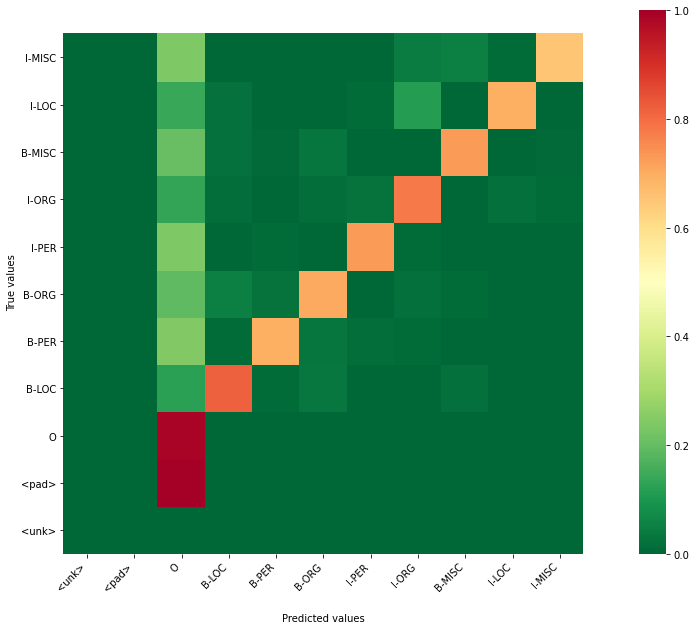

In [ ]:
gru_test_labels, gru_test_predictions = evaluate_on_test(gru_model, test_dataloader)
plot_confusion_matrix(gru_test_labels, gru_test_predictions, label_vocab)

# Exercises

## Pre-trained embeddings

Try to make use of the optional argument `pretrained_weights` in the `RNNTagger` module. You must define new vocabulary that makes use of the pretrained weights and then pass these to the model. 

_Hint: You can use some of the more popular ones like GloVe or FastText_

## Hyperparameters

The `RNNTagger` module accepts many initialization parameters, also called hyper-parameters. Try to play with them, read what they do in the PyTorch documentation for the respective module and report your findings. Are any of those parameters more important than the rest or lead to much better or worse performance?

## LSTMs

As you can see, it is fairly easy to swap between different types of recurrent neural networks. As an exercise, try to implement other types than the ones shown here. One of the most popular ones would be the [LSTM](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html). 

Once you have implemented it, report the results. Does it perform better or worse? What about the speed of training?

## Model checkpoints

As you can see from our original F1 score charts, both models have peaks that occur before the end of the training. However, as we continue training, we overwrite the parameters and weights that produced these "best" results. In real scenarios, we must store them somewhere and at the end of the training, resume the model state to the one that produced best results. 

Create another `train()` function and modify it in a way that when validating, you make sure to save the model if a new best result is found.

## Transformers

RNN are getting increasingly outperformed in the recent years by another type of models, namely the Transformer networks. There are many ways a Transformer network can be applied to NER. It can be ideally replace the whole model (`RNNTagger` in our example) and predict the entity tags on its own. However, due to the nature of these networks, they are extremely large and require tremendous amount of time to train. Due to this, most people nowadays use them in a feature extraction type of manner, by replacing the embeddings in one network with the transformer model. This can be further trained during the NER task which is then called "fine-tuning" of the parameters.

One of the most popular library for Transformers in Python is [HuggingFace](https://huggingface.co/). Try to implement BERT -- one of the most popular transformer models by following the library documentation. 

_Note that this requires higher amount of memory and GPU/CPU computation power. If you start getting memory errors, try reducing the size of batches and the model parameters._